In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
import math
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, RandomRotation, SeparableConv2D, Dropout
from tensorflow.keras import Input, Model
from sklearn.model_selection import train_test_split as tts
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.math import confusion_matrix
import seaborn as sns
import time

## Data Processing
### Data is ingested and made suitable for a CNN

In [2]:
trimmed_data = pd.read_csv("trimmed_dataset.csv",index_col=0)
trimmed_data.head()

,lesion_id,image_id,dx
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


In [3]:
trimmed_data.sort_values(by="lesion_id",axis=0,inplace=True)
# trimmed_data=pd.get_dummies(trimmed_data,columns=["dx"])
trimmed_data.drop("lesion_id",axis=1,inplace=True)
# trimmed_data.set_index("image_id",inplace=True)
trimmed_data.head()

,image_id,dx
9187,ISIC_0028498,nv
9188,ISIC_0025346,nv
726,ISIC_0027859,bkl
1661,ISIC_0032622,mel
1660,ISIC_0033848,mel


In [4]:
row_keys = trimmed_data.columns.values

In [5]:
d = dict(zip(trimmed_data["image_id"],trimmed_data["dx"]))
d['ISIC_0032622']

'mel'

In [6]:
train_dir = "C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/original_with_segmentation/train"
test_dir = "C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/original_with_segmentation/test"

In [25]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                       shuffle=True,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE)

Found 7962 files belonging to 7 classes.
Found 2053 files belonging to 7 classes.


In [26]:
class_names = train_dataset.class_names

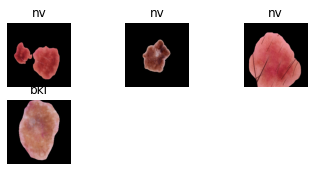

In [27]:
for images, labels in train_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [28]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
preprocess_input = tf.keras.applications.xception.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [29]:
val_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(val_batches // 10)
train_dataset = train_dataset.skip(val_batches // 10)

In [30]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 24
Number of test batches: 65


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [32]:
IMG_SHAPE = IMG_SIZE + (3,)

In [33]:
base_model = Xception(input_shape=IMG_SHAPE,
                    include_top=False,
                    weights='imagenet')

In [34]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [35]:
base_model.trainable = False

In [36]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [37]:
prediction_layer = tf.keras.layers.Dense(7,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


In [38]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [39]:
base_learning_rate = 0.00001
EPOCHS=400
callbacks = EarlyStopping(monitor="loss",patience=30,restore_best_weights=True)
lrPlateau = ReduceLROnPlateau(monitor="val_loss",patience=15)
NAME="xception-global-epochs-{}-blr-{}-time-{}".format(EPOCHS,base_learning_rate,time.time())
tensorboard = TensorBoard(log_dir="logs_imagenet/-{}".format(NAME))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [40]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [41]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.4f}".format(accuracy0))

24/24 [==============================] - 3s 62ms/step - loss: 1.8145 - accuracy: 0.2214
initial loss: 1.81
initial accuracy: 0.2214


In [42]:
history = model.fit(train_dataset,
                    verbose=1,
                    epochs=EPOCHS,
                    validation_data=test_dataset,
                   callbacks=[callbacks,tensorboard,lrPlateau])

Epoch 1/400
225/225 [==============================] - 21s 86ms/step - loss: 1.5506 - accuracy: 0.5095 - val_loss: 1.3367 - val_accuracy: 0.6493 - lr: 1.0000e-05
Epoch 2/400
225/225 [==============================] - 19s 83ms/step - loss: 1.2573 - accuracy: 0.6675 - val_loss: 1.1993 - val_accuracy: 0.6498 - lr: 1.0000e-05
Epoch 3/400
225/225 [==============================] - 19s 83ms/step - loss: 1.1622 - accuracy: 0.6718 - val_loss: 1.1522 - val_accuracy: 0.6498 - lr: 1.0000e-05
Epoch 4/400
225/225 [==============================] - 20s 87ms/step - loss: 1.1231 - accuracy: 0.6740 - val_loss: 1.1223 - val_accuracy: 0.6498 - lr: 1.0000e-05
Epoch 5/400
225/225 [==============================] - 20s 88ms/step - loss: 1.0929 - accuracy: 0.6746 - val_loss: 1.0973 - val_accuracy: 0.6498 - lr: 1.0000e-05
Epoch 6/400
225/225 [==============================] - 19s 85ms/step - loss: 1.0711 - accuracy: 0.6745 - val_loss: 1.0769 - val_accuracy: 0.6498 - lr: 1.0000e-05
Epoch 7/400
225/225 [=======

KeyboardInterrupt: 

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("Trained model loss: {:.2f}".format(loss0))
print("Trained model accuracy: {:.4f}".format(accuracy0))

In [ ]:
y_actual = np.array([])
preds = model.predict(validation_dataset)
for x in validation_dataset:
    # print(np.array(x[1]))
    # break
    y_actual = np.concatenate((y_actual,np.array(x[1])))

In [ ]:
preds = np.array([np.argmax(x) for x in preds])
preds

In [ ]:
conf = tf.math.confusion_matrix(y_actual,preds)

In [ ]:
ax = sns.heatmap(conf,annot=True,fmt=".3g",vmin=0,vmax=70)
ax.set_ylabel("Labels")
ax.set_xlabel("Predictions")

In [ ]:
pred_label, pred_count = np.unique(preds,return_counts=True)
pred_count

In [ ]:
actual_label, actual_count = np.unique(y_actual,return_counts=True)

In [ ]:
p_labels = [str(x)+" Predicted" for x in pred_label]
a_labels = [str(x)+" Actual" for x in actual_label]

In [ ]:
comb_labels = []

for i in range(7):
    comb_labels += [p_labels[i]]
    comb_labels += [a_labels[i]]

In [ ]:
f = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)

width = 0.35
x = np.arange(len(pred_label))

pred_bars = ax.bar(x - width/2, pred_count,width=width, color="red",label="Predicted Classification")
actual_bars = ax.bar(x + width/2, actual_count,width=width, color="green",label="Actual Classification")
ax.set_ylabel("Frequency")
ax.set_title("----------------")
ax.set_xticks(x,pred_label)
ax.legend()
ax.bar_label(pred_bars, padding=3)
ax.bar_label(actual_bars, padding=3)

f.tight_layout()
plt.show()